<a href="https://colab.research.google.com/github/AymenSe/malaria-detection/blob/main/Malaria_State_of_the_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/Datasets/MalariaDetction

/content/drive/MyDrive/Datasets/MalariaDetction


In [ ]:
!unzip cell_images.zip

#1- Helper functions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

#1- Loading Image Data

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop((62,62)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

valid_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop((62,62)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.CenterCrop((64,64)),
                                      transforms.ToTensor()])

In [ ]:
data_dir = 'cell_images/'

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as testing
test_size = 0.2
# percentage of training set to use as validation
valid_size = 0.1

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((62,62)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

dataset = datasets.ImageFolder(data_dir, transform=transform)
len_dataset = len(dataset)

# split dataset into train_data and test_data
# obtain training indices that will be used for testing
indices = list(range(len_dataset))
np.random.shuffle(indices)
test_split = int(np.floor(test_size * len_dataset))
train_valid_idx, test_idx = indices[test_split:], indices[:test_split]
valid_split = int(np.floor(valid_size * len(train_valid_idx)))
train_idx, valid_idx = train_valid_idx[valid_split:], train_valid_idx[:valid_split]

print(f"Train: {(len(train_idx) / len_dataset) * 100}%,\
        Valid: {(len(valid_idx) / len_dataset)* 100}%, \
        Test: {(len(test_idx) / len_dataset)* 100}%")


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

# Classes
classes = ["Parasitized", "Uninfected"]

Train: 72.00449960084187%,        Valid: 7.997677625371943%,         Test: 19.997822773786197%


#2- Visualize a Batch of Training Data

In [ ]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

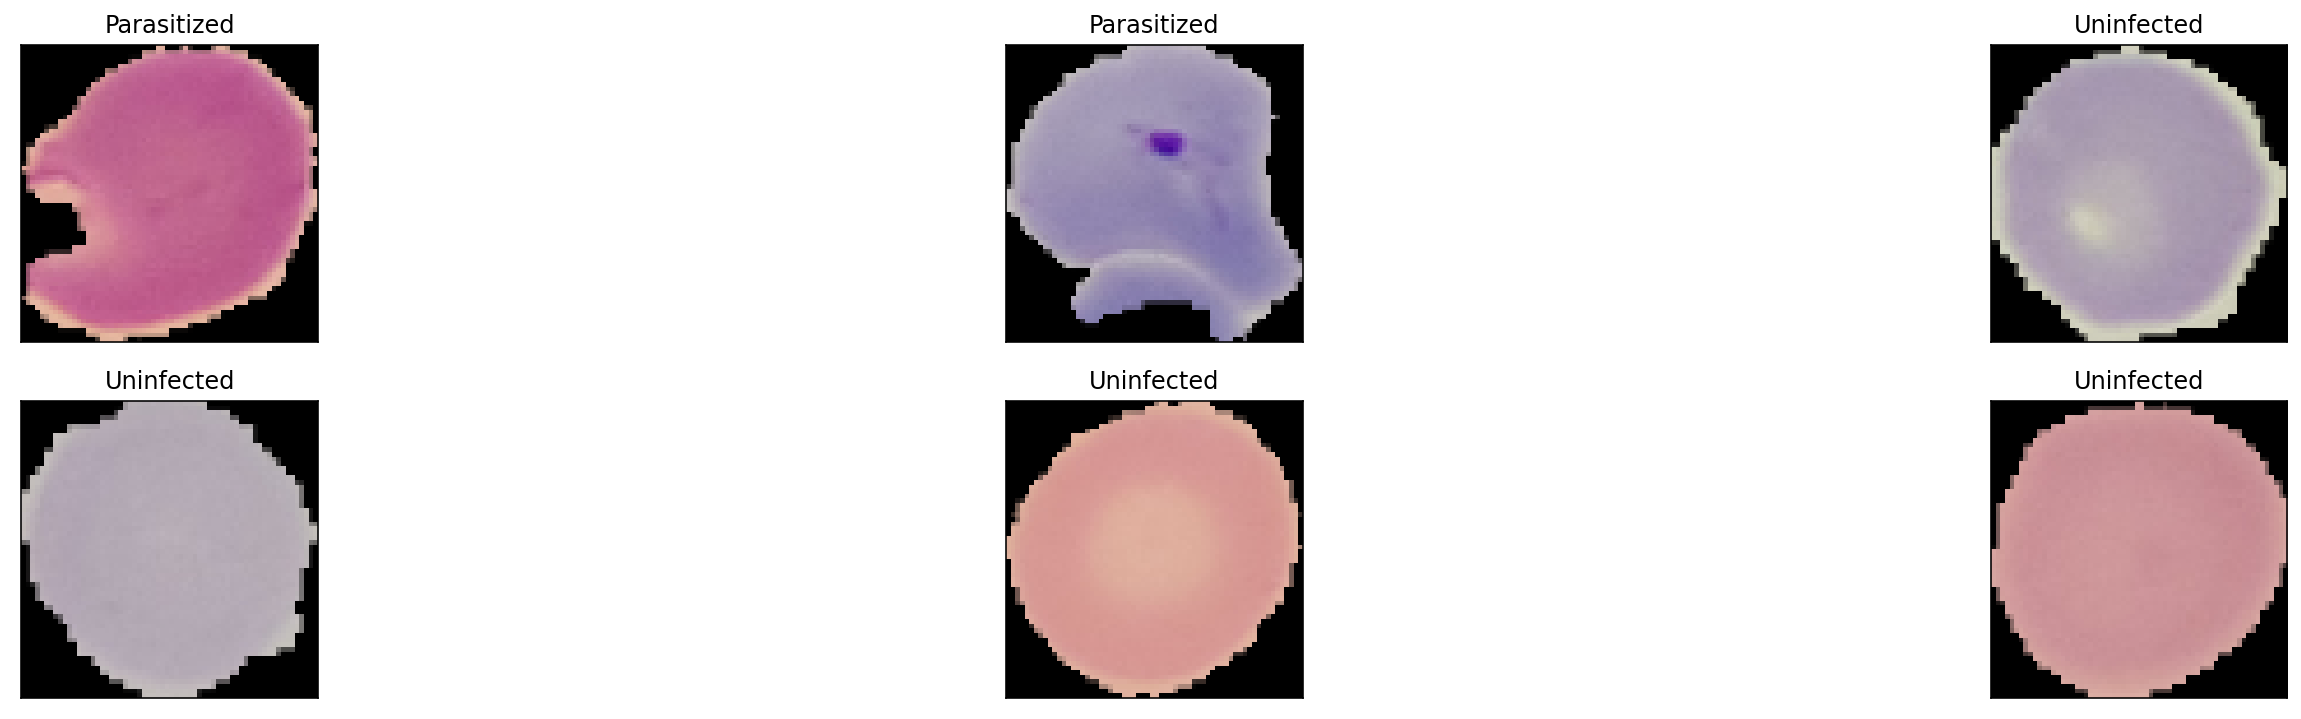

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 6))
# display 20 images
for idx in np.arange(6):
    ax = fig.add_subplot(2, 6/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

#3- Define the Network Architecture


>   A- CBAM attention



In [ ]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None


    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )


class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale,scale


class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate= SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out,att_map  = self.SpatialGate(x_out)
        return x_out,att_map 



> B- Classifer



In [ ]:
from torch import nn, sigmoid
from torch.nn.modules.upsampling import Upsample
from torch.nn.functional import interpolate
from torch.nn import MaxPool2d
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.activation import Sigmoid, ReLU
from torchvision.models import densenet121
import torch.nn.functional as F

class Classifier(nn.Module):


    """
    Classifier [one encoder , clssifier]
    """

    def  __init__(self):
        super(Classifier,self).__init__()

        self.encoder = torch.nn.Sequential(*densenet121(pretrained=True).features)
        self.attention =  CBAM(1024)
        self.classiifer = torch.nn.Sequential(nn.Linear(1024, 1))
        

        for m in self.attention.parameters():
                if isinstance(m, nn.Conv2d):
                  if "weight" in name:
                      nn.init.xavier_normal_(m)
                  elif "bias" in name:
                      nn.init.constant_(m, 0.0)
                elif isinstance(m, nn.Linear):
                      nn.init.xavier_uniform(m.weight)
                      nn.init.constant_(m.bias, 0)

        for m in self.classiifer.parameters():
            if isinstance(m, nn.Linear):
              nn.init.xavier_uniform(m.weight)
              nn.init.constant_(m.bias, 0)

        print("Model initialized, Malaria Classifier")

    # def set_freez(self,epoch):
    #     if epoch < 1:

    #       for name, param in self.named_parameters():
    #           if 'encoder' in name :
    #               param.requires_grad = False
    #           else :
    #               param.requires_grad = True

    #     else:        
    #       for name, param in self.named_parameters():
    #           param.requires_grad = True


    def forward(self, input):

        encoder_out = self.encoder(input)
        encoder_out, attention_map = self.attention(encoder_out)
        encoder_out = F.relu(encoder_out, inplace=True)
        encoder_out = F.adaptive_avg_pool2d(encoder_out, (1, 1))
        encoder_out = torch.flatten(encoder_out, 1)
        # Xray classifier 
        out = self.classiifer(encoder_out)
        return out, attention_map

model = Classifier()
print(model.cuda())

Model initialized, Malaria Classifier
Classifier(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


#4- Specify Loss Function and Optimizer

In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#5- Train the Network

In [ ]:
# number of epochs to train the model
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output, _ = model(data)
        # calculate the batch loss
        loss = criterion(output.squeeze(), target.type_as(output))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output, _ = model(data)
        # calculate the batch loss
        loss = criterion(output.squeeze(), target.type_as(output))
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.344467 	Validation Loss: 0.301037
Validation loss decreased (inf --> 0.301037).  Saving model ...
Epoch: 2 	Training Loss: 0.314100 	Validation Loss: 0.285402
Validation loss decreased (0.301037 --> 0.285402).  Saving model ...
Epoch: 3 	Training Loss: 0.301922 	Validation Loss: 0.293665
Epoch: 4 	Training Loss: 0.290947 	Validation Loss: 0.275524
Validation loss decreased (0.285402 --> 0.275524).  Saving model ...
Epoch: 5 	Training Loss: 0.285029 	Validation Loss: 0.287807
Epoch: 6 	Training Loss: 0.282296 	Validation Loss: 0.260924
Validation loss decreased (0.275524 --> 0.260924).  Saving model ...
Epoch: 7 	Training Loss: 0.277052 	Validation Loss: 0.270480
Epoch: 8 	Training Loss: 0.276557 	Validation Loss: 0.249847
Validation loss decreased (0.260924 --> 0.249847).  Saving model ...
Epoch: 9 	Training Loss: 0.276819 	Validation Loss: 0.253436
Epoch: 10 	Training Loss: 0.266752 	Validation Loss: 0.262551
Epoch: 11 	Training Loss: 0.264126 	Validation Lo

#6- Test the model 

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Datasets/MalariaDetction/model.pt'))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output, _ = model(data)
    # calculate the batch loss
    loss = criterion(output.squeeze(), target.type_as(output))
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if len(target) == 20:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        else:
          for j in range(11):
            label = target.data[j]
            class_correct[label] += correct[j].item()
            class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test Loss: 0.050708

Test Accuracy of Parasitized: 100% (2816/2816)
Test Accuracy of Uninfected:  0% ( 0/2904)

Test Accuracy (Overall): 49% (2816/5720)


#7- Visualize Sample Test Results

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))